In [50]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

### Creating multic-class dataset

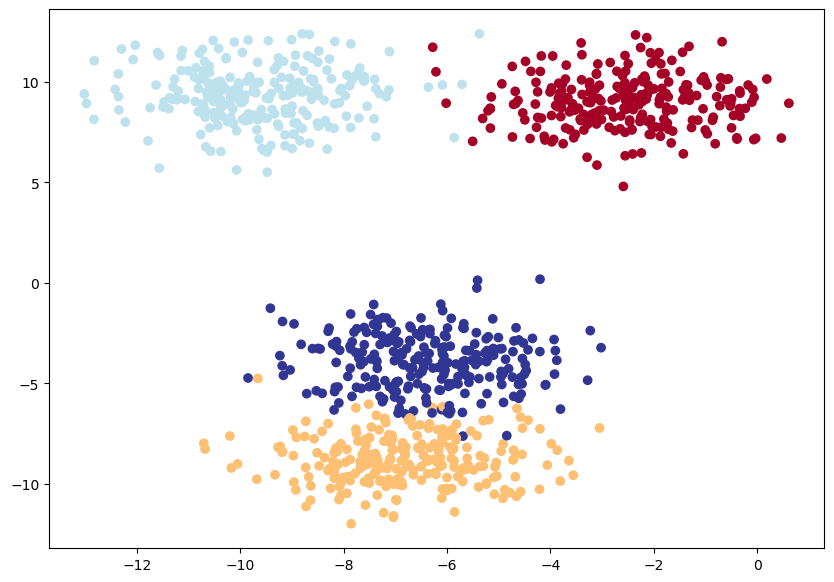

In [51]:
# Set hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATRUES = 5
RANDOM_SEED = 42

# Create multiclass data
XBlob, yBlob = make_blobs(n_samples=1000,
                          n_features=NUM_FEATRUES,
                          centers=NUM_CLASSES,
                          cluster_std=1.3,           # Give clusters a little shake up
                          random_state=RANDOM_SEED)

# Turn data into tensors
XBlob = torch.Tensor(XBlob)
yBlob = torch.LongTensor(yBlob)  # 64 bit Integer

# Split into train and test
XBlobTrain, XBlobTest, yBlobTrain, yBlobTest = train_test_split(XBlob, 
                                                                yBlob,
                                                                test_size=0.2,
                                                                random_state=RANDOM_SEED)

# Plot data
plt.figure(figsize=(10, 7))
plt.scatter(XBlob[:, 0], XBlob[:, 1], c=yBlob, cmap=plt.cm.RdYlBu)

In [52]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Add train and test data to gpu if available
XBlobTrain = XBlobTrain.to(device)
XBlobTest = XBlobTest.to(device)
yBlobTrain = yBlobTrain.to(device)
yBlobTest = yBlobTest.to(device)

XBlobTrain.shape, yBlobTrain.shape

(torch.Size([800, 5]), torch.Size([800]))

### Build a multi-class classification model

In [53]:
class BlobClassifier(nn.Module):
    def __init__(self, input_features, output_features, hidden_units):
        super().__init__()
        self.hiddenLayers = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )
    
    def forward(self, x):
        return self.hiddenLayers(x)

# Create an instance of BlobClassifier model
blobClassifierModel = BlobClassifier(input_features=5, output_features=4, hidden_units=8).to(device)

In [54]:
# Define a loss function
lossFunction = nn.CrossEntropyLoss()

# Define a optimizer
optimizer = torch.optim.SGD(params=blobClassifierModel.parameters(), lr=0.1)

In [55]:
# For reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Define the number of epochs
epochs = 1000

for epoch in range(epochs):
    ### Training
    blobClassifierModel.train()

    # Forward propagation
    trainLogits = blobClassifierModel(XBlobTrain)

    # Calculate loss
    trainLoss = lossFunction(trainLogits, yBlobTrain)

    # Zero grad optimizer
    optimizer.zero_grad()

    # Backpropagation
    trainLoss.backward()

    # Updata parameters
    optimizer.step()


    ### Testing
    blobClassifierModel.eval()

    with torch.inference_mode():
        # Forward porpagation
        testLogits = blobClassifierModel(XBlobTest)
        testPreds = torch.softmax(testLogits, dim=1).argmax(dim=1)  # Prediction 

        # Calculate loss
        testLoss = lossFunction(testLogits, yBlobTest)

    if epoch % 50 == 0:
        print(f"Epoch: {epoch}, Train Loss: {trainLoss}, Test Loss: {testLoss}")


Epoch: 0, Train Loss: 1.4341955184936523, Test Loss: 1.3761651515960693
Epoch: 50, Train Loss: 0.3914625942707062, Test Loss: 0.3798658847808838
Epoch: 100, Train Loss: 0.14552563428878784, Test Loss: 0.16340398788452148
Epoch: 150, Train Loss: 0.09070195257663727, Test Loss: 0.10280606895685196
Epoch: 200, Train Loss: 0.0635470375418663, Test Loss: 0.07279017567634583
Epoch: 250, Train Loss: 0.04801951348781586, Test Loss: 0.055152975022792816
Epoch: 300, Train Loss: 0.038257334381341934, Test Loss: 0.044024620205163956
Epoch: 350, Train Loss: 0.03162701055407524, Test Loss: 0.036495767533779144
Epoch: 400, Train Loss: 0.026866430416703224, Test Loss: 0.031072154641151428
Epoch: 450, Train Loss: 0.023304197937250137, Test Loss: 0.02700626850128174
Epoch: 500, Train Loss: 0.0205464456230402, Test Loss: 0.023861121386289597
Epoch: 550, Train Loss: 0.018351523205637932, Test Loss: 0.021359164267778397
Epoch: 600, Train Loss: 0.016564039513468742, Test Loss: 0.01932760886847973
Epoch: 650

#### Make predictions

In [56]:
# Predictions
blobClassifierModel.eval()

with torch.inference_mode():
    yPredLogits = blobClassifierModel(XBlobTest)

# View the first 10 predicted logits
yPredLogits[:10]

tensor([[ -1.8321,  11.6310, -10.4835,  -1.4798],
        [ -4.6954,  -2.3824,  -4.1586,   9.5780],
        [  8.0372,  -1.7859,  -4.4823,  -2.5281],
        [ -5.5372,  -6.5189,  -2.6605,  11.4825],
        [ -0.8260,  -1.3420,   3.2719,  -1.3448],
        [ -4.2041,  -2.7284,  -5.2329,  10.4253],
        [ -5.8248,  -6.5613,  -3.5509,  12.7533],
        [ -0.8260,  -1.3420,   3.2719,  -1.3448],
        [ -0.8260,  -1.3420,   3.2719,  -1.3448],
        [  7.9665,  -1.7824,  -4.4205,  -2.5186]], device='cuda:0')

In [57]:
# Prediction probabilities from predicted logits
yPredProbs = torch.softmax(yPredLogits, dim=1)
yPredProbs[:10]

tensor([[1.4225e-06, 1.0000e+00, 2.4878e-10, 2.0233e-06],
        [6.3259e-07, 6.3921e-06, 1.0821e-06, 9.9999e-01],
        [9.9992e-01, 5.4180e-05, 3.6546e-06, 2.5795e-05],
        [4.0591e-08, 1.5208e-08, 7.2068e-07, 1.0000e+00],
        [1.6024e-02, 9.5644e-03, 9.6487e-01, 9.5375e-03],
        [4.4315e-07, 1.9383e-06, 1.5839e-07, 1.0000e+00],
        [8.5439e-09, 4.0907e-09, 8.3023e-08, 1.0000e+00],
        [1.6024e-02, 9.5644e-03, 9.6487e-01, 9.5375e-03],
        [1.6024e-02, 9.5644e-03, 9.6487e-01, 9.5375e-03],
        [9.9991e-01, 5.8352e-05, 4.1720e-06, 2.7945e-05]], device='cuda:0')

In [58]:
# Prediction labels from predicted probabilities
yPredLabels = torch.argmax(yPredProbs, dim=1)
yPredLabels

tensor([1, 3, 0, 3, 2, 3, 3, 2, 2, 0, 3, 0, 1, 2, 0, 0, 3, 1, 2, 1, 2, 2, 1, 3,
        2, 1, 0, 2, 2, 1, 1, 3, 1, 3, 1, 0, 1, 2, 0, 3, 2, 3, 2, 0, 1, 2, 3, 2,
        2, 2, 3, 0, 0, 2, 3, 1, 2, 0, 3, 2, 3, 1, 3, 3, 1, 2, 3, 0, 1, 1, 2, 2,
        2, 1, 0, 0, 2, 0, 1, 2, 3, 2, 1, 3, 1, 0, 2, 2, 1, 0, 3, 0, 0, 1, 1, 0,
        2, 2, 3, 3, 2, 1, 2, 3, 1, 2, 3, 3, 2, 2, 2, 3, 1, 3, 1, 3, 3, 1, 3, 3,
        1, 1, 1, 0, 0, 0, 2, 1, 3, 1, 3, 0, 3, 0, 3, 3, 2, 1, 3, 0, 2, 3, 2, 3,
        1, 3, 2, 1, 2, 2, 0, 2, 3, 2, 1, 0, 3, 3, 0, 0, 0, 2, 1, 1, 3, 3, 3, 0,
        3, 1, 1, 2, 3, 1, 0, 2, 3, 2, 2, 3, 2, 1, 0, 0, 0, 2, 1, 2, 3, 1, 2, 0,
        2, 3, 0, 3, 1, 1, 1, 3], device='cuda:0')

In [59]:
print(yBlobTest == yPredLabels)

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, Tr

In [60]:
XBlobTrain.squeeze().shape, yBlobTrain.shape

(torch.Size([800, 5]), torch.Size([800]))

### Classification metrics to evaluate classification models
##### * Accuracy 
##### * Precision
##### * Recall
##### * F1-Score
##### * Confusion Matrix 
##### * Classification Report

In [64]:
import torchmetrics
from torchmetrics import Accuracy

# Setup accuracy metric
torchmetrics_accuracy = Accuracy(task="multiclass", num_classes=NUM_CLASSES).to(device)

# Calculate accuracy
print(f"Accuracy: {torchmetrics_accuracy(yPredLabels, yBlobTest)}")

Accuracy: 1.0
